# Домашнее задание 5.1

#### Импорт библиотек

In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from dotenv import load_dotenv
from pandas.errors import SettingWithCopyWarning

import os
import warnings
from pprint import pprint

#### Глобальные настройки

In [384]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

#### Предобработка данных
1. df_users:
    - Загрузил данные из файла `users.csv` в DataFrame
    - Поле `reg_date` привел к типу данных datetime
    - Поле `churn_date` привел к типу данных datetime
    - Добавил колонку `churn_month` - месяц
2. df_internet:
    - Загрузил данные из файла `internet.csv` в DataFrame
    - Удалил первую калонку из исходного файла
    - Поле `id` привел к нормальному виду 1000_1 заменил на 1 и т д
    - Поле `id` привел к ineger-у
    - Поле `session_date` привел к типу данных datetime
    - Добавил колонку `session_month` - месяц
3. df_messages:
    - Загрузил данные из файла `messages.csv` в DataFrame
    - Поле `id` привел к нормальному виду 1000_1 заменил на 1 и т д
    - Поле `id` привел к ineger-у
    - Поле `message_date` привел к типу данных datetime
    - Добавил колонку `message_month` - месяц
4. df_calls:
    - Загрузил данные из файла `calls.csv` в DataFrame
    - Поле `id` привел к нормальному виду 1000_1 заменил на 1 и т д
    - Поле `id` привел к ineger-у
    - Поле `call_date` привел к типу данных datetime
    - Добавил колонку `call_month` - месяц
5. df_tariffs:
    - Загрузил данные из файла `tariffs.csv` в DataFrame

In [385]:
df_users = pd.read_csv('../datasets/CSV/users.csv')
df_internet = pd.read_csv('../datasets/CSV/internet.csv', usecols=lambda x: x not in ['Unnamed: 0'])
df_messages = pd.read_csv('../datasets/CSV/messages.csv')
df_calls = pd.read_csv('../datasets/CSV/calls.csv')
df_tariffs = pd.read_csv('../datasets/CSV/tariffs.csv')


df_internet['id'] = df_internet['id'].str.replace(r'^\d+_', '', regex=True)
df_internet['id'] = df_internet['id'].astype(int)
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])
df_internet['session_month'] = df_internet['session_date'].dt.month

df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])
df_users['churn_month'] = df_users['churn_date'].dt.month

df_messages['id'] = df_messages['id'].str.replace(r'^\d+_', '', regex=True)
df_messages['id'] = df_messages['id'].astype(int)
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_messages['message_month'] = df_messages['message_date'].dt.month

df_calls['id'] = df_calls['id'].str.replace(r'^\d+_', '', regex=True)
df_calls['id'] = df_calls['id'].astype(int)
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_calls['call_month'] = df_calls['call_date'].dt.month

#### Информация о данных

In [386]:
def get_info_df(data, info_df={}):

    info_df['0. Размер DataFrame'] = data.shape
    info_df['1. Индексы DataFrame'] = data.index
    info_df['2. Колонки DataFrame'] = list(data.columns.values)
    info_df['3. Числовые колонки'] = dict(data.select_dtypes(include=[int, float, complex]).dtypes)
    info_df['4. Строковые колонки'] = dict(data.select_dtypes(include=[object]).dtypes)
    info_df['5. Колонки с пропусками'] = list(data.columns[data.isnull().any()])
    info_df['6. Строки с пропусками'] = list(data[data.isnull().any(axis=1)].index.values)
    info_df['7. Колличество строк без пропусков'] = len(data.value_counts())
    info_df['8. Колличество полных дубликатов'] = len(data[data.duplicated(keep=False)])
    info_df['9. Колличество занимаемой памяти'] = f"{round(data.memory_usage(deep=True).sum() / 1048576, 2)} мегабайт"

    display(data.head())
    return info_df

# Раскоментируй

# pprint(get_info_df(df_users), width=400, compact=True)     # df_users
# pprint(get_info_df(df_internet), width=400, compact=True)  # df_internet
# pprint(get_info_df(df_messages), width=400, compact=True)  # df_messages
# pprint(get_info_df(df_calls), width=400, compact=True)     # df_calls
# pprint(get_info_df(df_tariffs), width=400, compact=True)   # df_tariffs


#### Собираем данные
- Подсчет количества звонков и длительности по месяцам для каждого пользователя
- Подсчет количества сообщений по месяцам для каждого пользователя
- Подсчет объема интернет-трафика по месяцам для каждого пользователя
- Объединение данных о пользователях и тарифах
- Объединение всех данных по месяцам
- Объединение с данными о тарифах
- Заполнение пропусков нулями для подсчетов
- Расчет помесячной выручки
- Оставляем нужные колонки

In [387]:
calls_user_month = df_calls.groupby(['user_id', 'call_month']).agg(total_calls=('id', 'count'), total_minutes=('duration', 'sum') ).reset_index()
messages_user_month = df_messages.groupby(['user_id', 'message_month']).agg(total_messages=('id', 'count')).reset_index()
internet_user_month = df_internet.groupby(['user_id', 'session_month']).agg(total_mb_used=('mb_used', 'sum')).reset_index()

df_users_tariffs = df_users.merge(df_tariffs, left_on='tariff', right_on='tariff_name', how='left')

user_data = calls_user_month.merge(messages_user_month, left_on=['user_id', 'call_month'], right_on=['user_id', 'message_month'], how='outer')
user_data = user_data.merge(internet_user_month, left_on=['user_id', 'call_month'], right_on=['user_id', 'session_month'], how='outer')
user_data['month'] = user_data['call_month'].fillna(user_data['message_month']).fillna(user_data['session_month']).astype(int)
user_data = user_data.drop(['call_month', 'message_month', 'session_month'], axis=1)

user_data = user_data.merge(df_users_tariffs, on='user_id', how='left')

user_data['total_calls'] = user_data['total_calls'].fillna(0)
user_data['total_minutes'] = user_data['total_minutes'].fillna(0)
user_data['total_messages'] = user_data['total_messages'].fillna(0)
user_data['total_mb_used'] = user_data['total_mb_used'].fillna(0)

user_data['minutes_over'] = (user_data['total_minutes'] - user_data['minutes_included']).clip(lower=0)
user_data['messages_over'] = (user_data['total_messages'] - user_data['messages_included']).clip(lower=0)
user_data['mb_over'] = (user_data['total_mb_used'] - user_data['mb_per_month_included']).clip(lower=0)

user_data['revenue'] = (
    user_data['rub_monthly_fee'] +
    user_data['minutes_over'] * user_data['rub_per_minute'] +
    user_data['messages_over'] * user_data['rub_per_message'] +
    (user_data['mb_over'] / 1024).apply(np.ceil) * user_data['rub_per_gb']
)

result = user_data[['user_id', 'month', 'total_calls', 'total_minutes', 'total_messages', 'total_mb_used', 'revenue', 'tariff_name']]
display(result.head())
display(result.tail())

,user_id,month,total_calls,total_minutes,total_messages,total_mb_used,revenue,tariff_name
0,1000,5,22.0,150.06,22.0,2253.49,1950.0,ultra
1,1000,6,43.0,158.90,60.0,23233.77,1950.0,ultra
2,1000,7,47.0,318.80,75.0,14003.64,1950.0,ultra
3,1000,8,52.0,389.87,81.0,14055.93,1950.0,ultra
4,1000,9,58.0,440.14,57.0,14568.91,1950.0,ultra


,user_id,month,total_calls,total_minutes,total_messages,total_mb_used,revenue,tariff_name
3248,1498,10,41.0,232.63,42.0,20579.36,1750.0,smart
3249,1499,9,9.0,64.65,11.0,1845.75,550.0,smart
3250,1499,10,68.0,429.91,48.0,17788.51,1150.0,smart
3251,1499,11,74.0,576.50,59.0,17963.31,1406.5,smart
3252,1499,12,69.0,465.16,66.0,13055.58,598.0,smart


#### Визуализация
- Общая колличество звонков по месяцам
- Сколько выручки принес конкретный пользователь
- Количество сообщений по месяцам
- Объем интернет-трафика по месяцам
- Помесячная выручка
- Выручка по тарифам


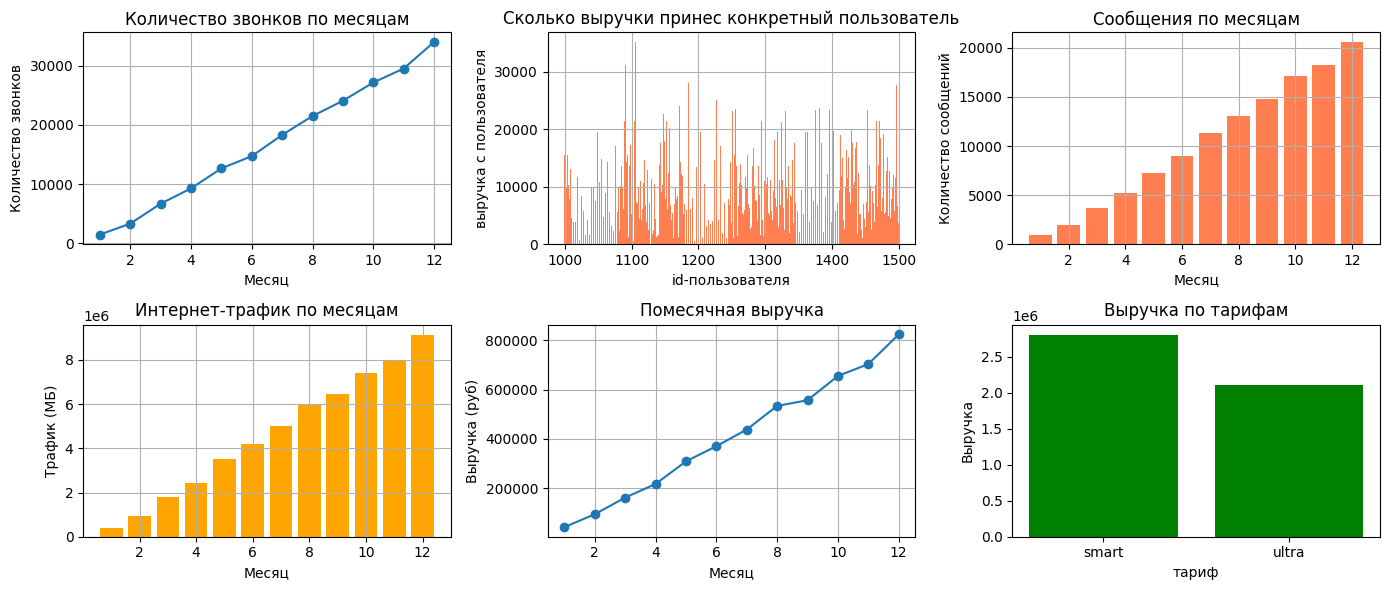

In [388]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6))


calls_per_month_sum = result.groupby('month')['total_calls'].sum().reset_index()
minutes_per_month_sum = result.groupby('month')['total_minutes'].sum().reset_index()
messages_per_month_sum = result.groupby('month')['total_messages'].sum().reset_index()
mb_per_month_sum = result.groupby('month')['total_mb_used'].sum().reset_index()
revenue_per_month_sum = result.groupby('month')['revenue'].sum().reset_index()
tarrif_rev = result.groupby('tariff_name')['revenue'].sum().reset_index()
user_rev = result.groupby('user_id')['revenue'].sum().reset_index()


ax[0, 0].plot(calls_per_month_sum['month'], calls_per_month_sum['total_calls'], marker='o')
ax[0, 0].set_xlabel('Месяц')
ax[0, 0].set_ylabel('Количество звонков')
ax[0, 0].set_title('Количество звонков по месяцам')
ax[0, 0].grid(True)

ax[0, 1].bar(user_rev['user_id'], user_rev['revenue'], color='coral')
ax[0, 1].set_xlabel('id-пользователя')
ax[0, 1].set_ylabel('выручка с пользователя')
ax[0, 1].set_title('Сколько выручки принес конкретный пользователь')
ax[0, 1].grid(True)

ax[0, 2].bar(messages_per_month_sum['month'], messages_per_month_sum['total_messages'], color='coral')
ax[0, 2].set_xlabel('Месяц')
ax[0, 2].set_ylabel('Количество сообщений')
ax[0, 2].set_title('Сообщения по месяцам')
ax[0, 2].grid(True)

ax[1, 0].bar(mb_per_month_sum['month'], mb_per_month_sum['total_mb_used'], color='orange')
ax[1, 0].set_xlabel('Месяц')
ax[1, 0].set_ylabel('Трафик (МБ)')
ax[1, 0].set_title('Интернет-трафик по месяцам')
ax[1, 0].grid(True)

ax[1, 1].plot(revenue_per_month_sum['month'], revenue_per_month_sum['revenue'], marker='o')
ax[1, 1].set_xlabel('Месяц')
ax[1, 1].set_ylabel('Выручка (руб)')
ax[1, 1].set_title('Помесячная выручка')
ax[1, 1].grid(True)

ax[1, 2].bar(tarrif_rev['tariff_name'], tarrif_rev['revenue'], color='green')
ax[1, 2].set_xlabel('тариф')
ax[1, 2].set_ylabel('Выручка')
ax[1, 2].set_title('Выручка по тарифам')



plt.tight_layout()
plt.show()

#### Вывод:
- Наиболее прибыльный тариф smart
- Декабрь показал лучшие показатели почти по всем метрикам

Где-то што-то я упустил , разберусь с этим